In [19]:
import os
import csv
import pandas as pd
import numpy as np
import statistics
import json
import dill
import wget
import matplotlib.pyplot as plt
from itertools import cycle
from scipy.fftpack import fft
from Bio import Entrez, SeqIO
from tqdm import tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

### Setup

Primeiramente é feita a filtragem dos Dados iniciais.

In [23]:
os.makedirs('./data/raw', exist_ok=True)

classes = ['Helitron', 'LINE', 'LTR', 'MITE', 'SINE', 'TIR']

file_paths = os.listdir('./data/raw')
print(file_paths)

for name in classes:
    if f'TEAnnotationFinal_{name}.gff3' not in file_paths:
        wget.download(f'http://apte.cp.utfpr.edu.br/te-annotation/zea_mays/TEAnnotationFinal_{name}.gff3',
                      out=f'./data/raw/')

file_paths = os.listdir('./data/raw')

print(file_paths)

['TEAnnotationFinal_TIR.gff3', 'TEAnnotationFinal_LTR.gff3', 'TEAnnotationFinal_LINE.gff3', 'TEAnnotationFinal_SINE.gff3', 'TEAnnotationFinal_MITE.gff3', 'TEAnnotationFinal_Helitron.gff3']
['TEAnnotationFinal_TIR.gff3', 'TEAnnotationFinal_LTR.gff3', 'TEAnnotationFinal_LINE.gff3', 'TEAnnotationFinal_SINE.gff3', 'TEAnnotationFinal_MITE.gff3', 'TEAnnotationFinal_Helitron.gff3']


In [4]:
data_df = pd.DataFrame()

if not os.path.isfile('./data/classes.csv'):
    data = []

    for path in file_paths:
        with open(f'./data/raw/{path}', 'r') as f:
            reader = csv.reader(f, delimiter='\t')

            class_name = path.split('.')[0].split('_')[1]

            for row in reader:
                if (row[6] == '+'):
                    data.append([class_name] + row)

    header = ['Class', 'Chr', 'Source Annotation', 'Class/Order/Superfamily', 'Start', 'End', 'Score', 'Strand', 'Phase', 'Attributes']

    data_df = pd.DataFrame(data, columns=header)
    data_df = data_df[['Class', 'Chr', 'Start', 'End']]

    data_df.to_csv('./data/classes.csv')

else:
    data_df = pd.read_csv('./data/classes.csv')

In [5]:
data_df['Start'] = data_df['Start'].astype('int64')
data_df['End'] = data_df['End'].astype('int64')

Em sequência será feita a extração dos genomas por meio de Biopython

In [6]:
id_dict = {"LR618874.1": "Chr_1.txt", "LR618875.1": "Chr_2.txt", "LR618876.1": "Chr_3.txt", "LR618877.1": "Chr_4.txt", 
           "LR618878.1": "Chr_5.txt", "LR618879.1": "Chr_6.txt", "LR618880.1": "Chr_7.txt", "LR618881.1": "Chr_8.txt", 
           "LR618882.1": "Chr_9.txt", "LR618883.1": "Chr_10.txt", "AY506529.1":"Chr_Mt.txt", "X86563.2": "Chr_Pt.txt"}

Entrez.email = "pedro.guilherme2305@usp.br"

os.makedirs('./data/sequences', exist_ok=True)

for id in tqdm(id_dict, total=len(id_dict)):
    if not os.path.isfile(f'./data/sequences/{id_dict[id]}'):
        stream = Entrez.efetch(db="nuccore", id=id, rettype="fasta")

        with open(f"./data/sequences/{id_dict[id]}", "w") as file:
            file.write(stream.read())
        stream.close()

100%|██████████| 12/12 [00:00<00:00, 22940.59it/s]


### Processamento

In [7]:
def generate_sequences(data_df: pd.DataFrame):
    chromosomes_to_keep = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Mt', 'Pt']
    data_df = data_df.query("Chr in @chromosomes_to_keep") 

    aux_list = []

    for chromosome in chromosomes_to_keep:
        rows = data_df.query(f"Chr == '{chromosome}'").to_dict(orient="records")
        record = SeqIO.read(f"./data/sequences/Chr_{chromosome}.txt", "fasta")
        for row in tqdm(rows, total=len(rows)):
            aux_dict = dict()

            aux_dict['Chr'] = row['Chr']
            aux_dict['Sequence'] = record[row['Start']:row['End']].seq
            aux_dict['Class'] = row['Class']

            if aux_dict['Sequence'] == '': aux_dict['Sequence'] = np.nan

            aux_list.append(aux_dict)
    
    return aux_list

### Feauture Extraction - Accumulated Nucle Frequency Fourier

In [8]:
def feature_extraction(spectrum, spectrumTwo):
    features = []

    average = sum(spectrum)/len(spectrum)
    features.append(average)
    ###################################
    median = np.median(spectrum)
    features.append(median)
	###################################
    maximum = np.max(spectrum)
    features.append(maximum)
    ###################################
    minimum = np.min(spectrum)
    features.append(minimum)
    ###################################
    peak = (len(spectrum)/3)/(average)
    features.append(peak)
    ###################################
    peak_two = (len(spectrumTwo)/3)/(np.mean(spectrumTwo))
    features.append(peak_two)
    ###################################
    standard_deviation = np.std(spectrum) # standard deviation
    features.append(standard_deviation)
    ###################################
    standard_deviation_pop = statistics.stdev(spectrum) # population sample standard deviation 
    features.append(standard_deviation_pop)
    ###################################
    percentile15 = np.percentile(spectrum, 15)
    features.append(percentile15)
    ###################################
    percentile25 = np.percentile(spectrum, 25)
    features.append(percentile25)
    ###################################
    percentile50 = np.percentile(spectrum, 50)
    features.append(percentile50)
    ###################################
    percentile75 = np.percentile(spectrum, 75)
    features.append(percentile75)
    ###################################
    amplitude = maximum - minimum
    features.append(amplitude)
    ###################################
    # mode = statistics.mode(spectrum)
    ###################################
    variance = statistics.variance(spectrum)
    features.append(variance)
    ###################################
    interquartile_range = np.percentile(spectrum, 75) - np.percentile(spectrum, 25)
    features.append(interquartile_range)
    ###################################
    semi_interquartile_range = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25))/2 
    features.append(semi_interquartile_range)
    ###################################
    coefficient_of_variation = standard_deviation/average
    features.append(coefficient_of_variation)
    ###################################
    skewness = (3 * (average - median))/standard_deviation
    features.append(skewness)   
    ###################################
    kurtosis = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / (2 * (np.percentile(spectrum, 90) - np.percentile(spectrum, 10))) 
    features.append(kurtosis)
    ###################################
    return features


def accumulated_nucle_frequency_fourier(seq):
    
    seq = seq.upper()
    features = []
    spectrum = []
    spectrumTwo = []
    mapping = []
    A = 0
    C = 0
    T = 0
    G = 0
    for i in range(len(seq)):
        if seq[i] == 'A':
            A += 1
            mapping.append(A / (i + 1))
        elif seq[i] == 'C':
            C += 1
            mapping.append(C / (i + 1))
        elif seq[i] == 'T' or seq[i] == 'U':
            T += 1
            mapping.append(T / (i + 1))
        else:
            G += 1
            mapping.append(G / (i + 1))
    Fmap = fft(mapping)
    for i in range(len(mapping)):
        specTotal = (abs(Fmap[i])**2)
        specTwo = (abs(Fmap[i]))
        spectrum.append(specTotal)
        spectrumTwo.append(specTwo)
    
    features = feature_extraction(spectrum, spectrumTwo)

    return features

In [9]:
def generate_features(final_df: pd.DataFrame, columns: list):
    features_dict = {}

    if not os.path.isfile('./data/features.json'):
        sequence_list = final_df['Sequence'].to_list()

        features_list = []
        for seq in tqdm(sequence_list, total=len(sequence_list)):
            features_list.append(accumulated_nucle_frequency_fourier(seq))

        features_list = np.array(features_list)
 
        features_dict = {}
        for i in tqdm(range(len(columns))):
            features_dict[columns[i]] = list(features_list[:, i])

        with open('./data/features.json', 'w') as f: 
            json.dump(features_dict, f)

    else:
        with open('./data/features.json', 'r') as f: 
            features_dict = json.load(f)
    
    return features_dict

In [10]:
columns = ['average', 'median', 'maximum', 'minimum', 'peak', 'none_levated_peak', 'sample_standard_deviation', 'population_standard_deviation', \
        'percentile15', 'percentile25', 'percentile50', 'percentile75', 'amplitude', 'variance', 'interquartile_range', 'semi_interquartile_range', \
        'coefficient_of_variation', 'skewness', 'kurtosis']

if not os.path.isfile('./data/final.csv'):
    aux_list = generate_sequences(data_df)

    final_df = pd.DataFrame(aux_list)
    final_df = final_df.dropna()
    final_df.head()

    features_dict = generate_features(final_df, columns)

    for column in columns:
        final_df[column] = features_dict[column]

    final_df = final_df.dropna()
    final_df.head()

    final_df.to_csv('./data/final.csv')

else:
    final_df = pd.read_csv('./data/final.csv')

/tmp/ipykernel_825746/3046178905.py:23: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv('./data/final.csv')


### Machine Learning

In [11]:
final_df = final_df[[column for column in final_df.columns if column != 'Unnamed: 0']]

In [12]:
final_df.groupby('Class')['Chr'].count()

Class
Helitron     24513
LINE         11058
LTR         189795
MITE         26094
SINE          3697
TIR          83113
Name: Chr, dtype: int64

In [13]:
class_list = final_df['Class'].to_list()
le = LabelEncoder()
y = le.fit_transform(class_list)

columns = ['average', 'median', 'maximum', 'minimum', 'peak', 'none_levated_peak', 'sample_standard_deviation', 'population_standard_deviation', \
            'percentile15', 'percentile25', 'percentile50', 'percentile75', 'amplitude', 'variance', 'interquartile_range', 'semi_interquartile_range', \
            'coefficient_of_variation', 'skewness', 'kurtosis']

x = final_df[columns].values

In [14]:
x_resample, y_resample = NearMiss(sampling_strategy={0:15000, 2:15000, 3:15000, 5:15000}).fit_resample(x, y)
x_resample, y_resample = SMOTE(sampling_strategy={1: 15000, 4:15000}).fit_resample(x_resample, y_resample)
y_resample = label_binarize(y_resample, classes=[0, 1, 2, 3, 4, 5])
x_train, x_test, y_train, y_test = train_test_split(x_resample, y_resample, test_size=0.3)

In [15]:
classifier = make_pipeline(StandardScaler(), OneVsRestClassifier(RandomForestClassifier(criterion='gini', n_estimators=100)))

In [16]:
classifier_list = []
criterion_list = ['gini', 'log_loss']
tree_num_list = [50, 100, 200]
for tree_num in tree_num_list:
    for criterion in criterion_list:
        classifier = make_pipeline(StandardScaler(), OneVsRestClassifier(RandomForestClassifier(criterion=criterion, n_estimators=tree_num)))
        classifier_list.append({'criterion':criterion, 'tree_num': tree_num, 'classifier': classifier})

In [ ]:
path = './data/classifiers/'
os.makedirs(path, exist_ok=True)

for classifier in tqdm(classifier_list, total=len(classifier_list)):
    
    file_name = f"classifier_{classifier['criterion']}_{classifier['tree_num']}.pkl"

    if file_name in list(os.listdir('./data/classifiers/')):
        with open(f'{path}/{file_name}', 'rb') as f: classifier['classifier'] = dill.load(f)
    else:
        classifier['classifier'].fit(x_train, y_train)
        with open(f'{path}/{file_name}', 'wb') as f: dill.dump(classifier['classifier'], f)

100%|██████████| 6/6 [00:19<00:00,  3.30s/it]


In [18]:
displays = []

for classifier in classifier_list:
    y_pred = classifier['classifier'].predict(x_test)
    print(classification_report(y_test, y_pred, target_names=['Helitron', 'LINE', 'LTR', 'MITE', 'SINE', 'TIR']))

    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_test.ravel(), y_pred.ravel()
    )
    average_precision["micro"] = average_precision_score(y_test, y_pred, average="micro")

    displays.append(average_precision)

/home/pedrohenrique/micromamba/envs/bioinfo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Helitron       0.92      0.79      0.85      4455
        LINE       0.91      0.71      0.80      4470
         LTR       0.96      0.74      0.84      4556
        MITE       0.90      0.75      0.82      4545
        SINE       0.94      0.55      0.69      4413
         TIR       0.93      0.74      0.83      4561

   micro avg       0.93      0.71      0.81     27000
   macro avg       0.93      0.71      0.80     27000
weighted avg       0.93      0.71      0.80     27000
 samples avg       0.71      0.71      0.71     27000



/home/pedrohenrique/micromamba/envs/bioinfo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Helitron       0.93      0.79      0.85      4455
        LINE       0.92      0.71      0.80      4470
         LTR       0.97      0.74      0.84      4556
        MITE       0.90      0.74      0.81      4545
        SINE       0.94      0.55      0.69      4413
         TIR       0.93      0.74      0.83      4561

   micro avg       0.93      0.71      0.81     27000
   macro avg       0.93      0.71      0.80     27000
weighted avg       0.93      0.71      0.80     27000
 samples avg       0.71      0.71      0.71     27000



/home/pedrohenrique/micromamba/envs/bioinfo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Helitron       0.92      0.79      0.85      4455
        LINE       0.91      0.72      0.81      4470
         LTR       0.97      0.74      0.84      4556
        MITE       0.90      0.74      0.81      4545
        SINE       0.94      0.55      0.70      4413
         TIR       0.93      0.75      0.83      4561

   micro avg       0.93      0.72      0.81     27000
   macro avg       0.93      0.72      0.81     27000
weighted avg       0.93      0.72      0.81     27000
 samples avg       0.72      0.72      0.72     27000



/home/pedrohenrique/micromamba/envs/bioinfo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Helitron       0.93      0.79      0.85      4455
        LINE       0.91      0.72      0.81      4470
         LTR       0.98      0.74      0.84      4556
        MITE       0.90      0.75      0.82      4545
        SINE       0.94      0.56      0.70      4413
         TIR       0.94      0.74      0.83      4561

   micro avg       0.93      0.72      0.81     27000
   macro avg       0.93      0.72      0.81     27000
weighted avg       0.93      0.72      0.81     27000
 samples avg       0.72      0.72      0.72     27000



/home/pedrohenrique/micromamba/envs/bioinfo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Helitron       0.92      0.79      0.85      4455
        LINE       0.91      0.72      0.81      4470
         LTR       0.98      0.74      0.84      4556
        MITE       0.90      0.75      0.82      4545
        SINE       0.94      0.56      0.70      4413
         TIR       0.93      0.74      0.83      4561

   micro avg       0.93      0.72      0.81     27000
   macro avg       0.93      0.72      0.81     27000
weighted avg       0.93      0.72      0.81     27000
 samples avg       0.72      0.72      0.72     27000

              precision    recall  f1-score   support

    Helitron       0.92      0.79      0.85      4455
        LINE       0.91      0.72      0.81      4470
         LTR       0.98      0.74      0.84      4556
        MITE       0.91      0.75      0.82      4545
        SINE       0.94      0.56      0.70      4413
         TIR       0.94      0.74      0.83      4561

   micro avg       0.93

/home/pedrohenrique/micromamba/envs/bioinfo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


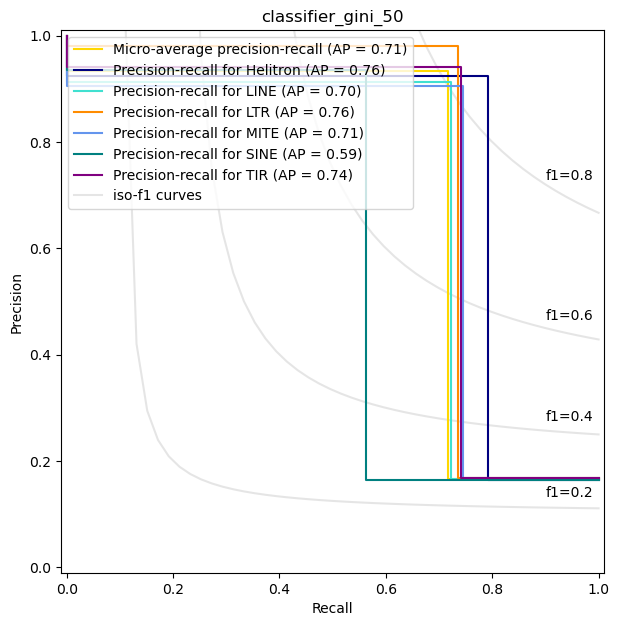

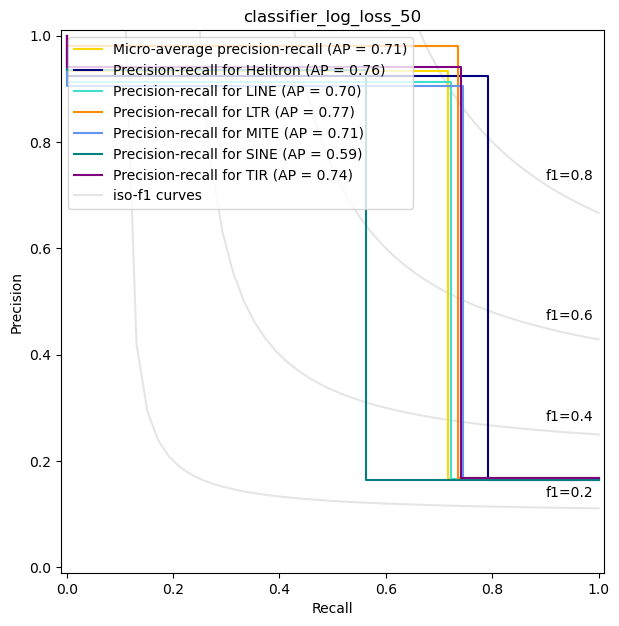

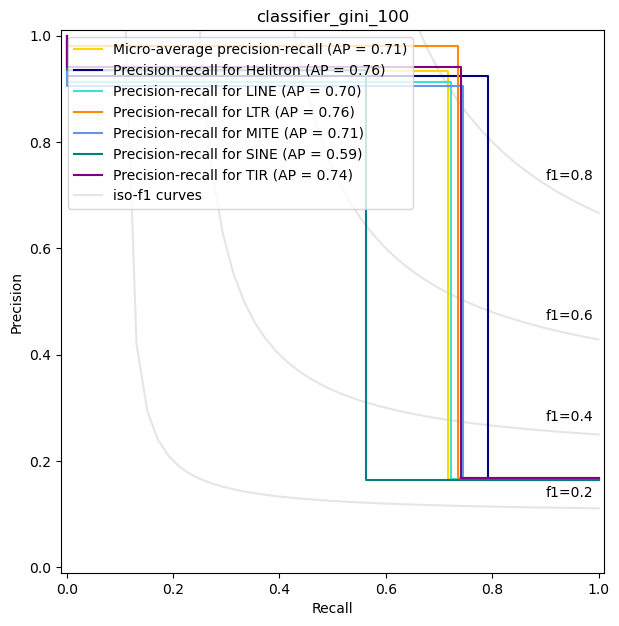

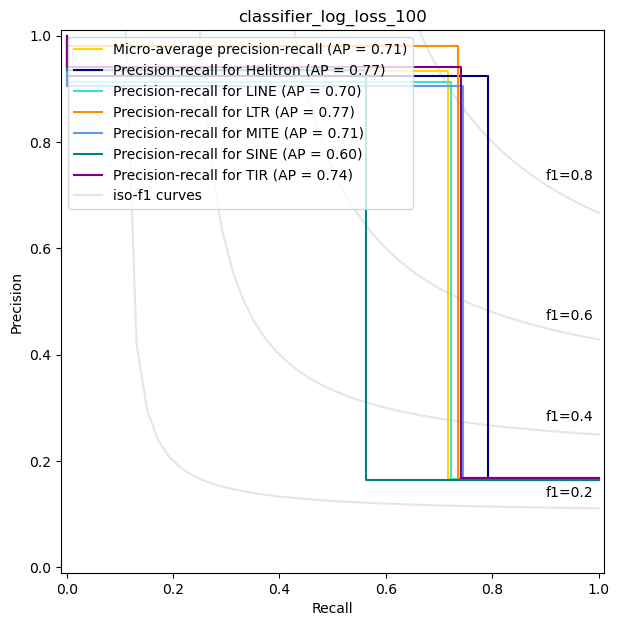

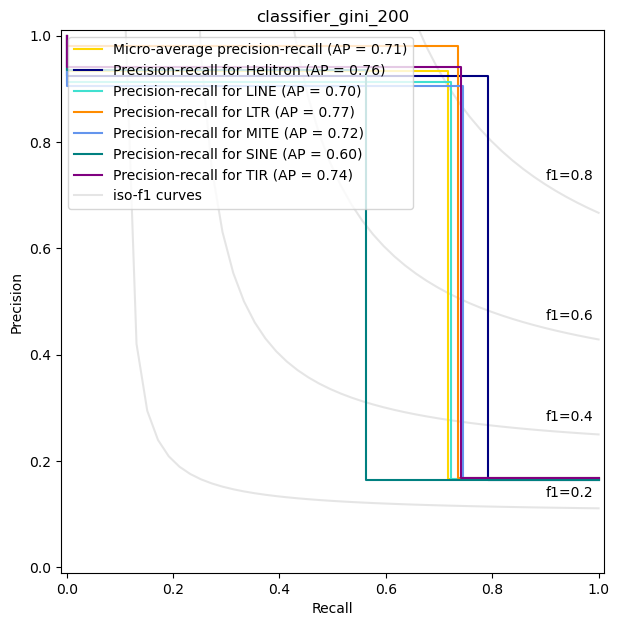

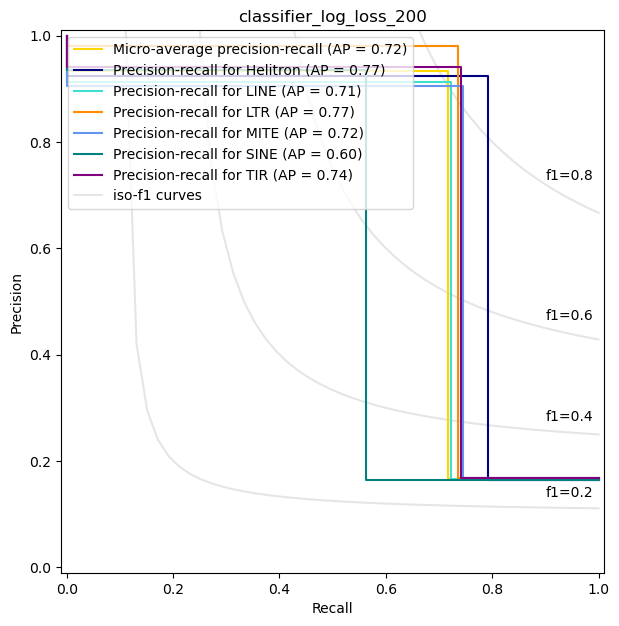

In [28]:
for average_precision, classifier in zip(displays, classifier_list):
    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal", "purple"])

    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(len(classes)), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for {classes[i]}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title(f"classifier_{classifier['criterion']}_{classifier['tree_num']}")

    plt.show()